# Analysis of the variance of performance at different levels

In [43]:
from itertools import zip_longest

import numpy as np

from lcdb.analysis.json import QueryAnchorValues
from lcdb.analysis.json import QueryMetricValuesFromAnchors

from lcdb.analysis.score import balanced_accuracy_from_confusion_matrix

from lcdb.db import LCDB


lcdb_path = "/Volumes/T7/lcdb/campaign_snellius"
db = LCDB(lcdb_path)

In [16]:
# which workflows are available?...

In [159]:
# workflow  = "KNNWorkflow"
# workflow  = "LibLinearWorkflow"
# workflow  = "LibSVMWorkflow"
workflow  = "TreesEnsembleWorkflow"
openml_id = 6

df = db.query(
    workflows=[f"lcdb.workflow.sklearn.{workflow}"],
    openmlids=[str(openml_id)],
    json_query=QueryAnchorValues(),
    verbose=True,
)
df.rename(columns={"JSON_QUERY": "ANCHORS"}, inplace=True)

100%|██████████| 24/24 [03:01<00:00,  7.58s/it]


In [160]:
df["METRICS"] = db.query(
    workflows=[f"lcdb.workflow.sklearn.{workflow}"],
    openmlids=[str(openml_id)],
    json_query=QueryMetricValuesFromAnchors("confusion_matrix", split_name="val"),
    verbose=True,
)["JSON_QUERY"]

100%|██████████| 24/24 [03:09<00:00,  7.88s/it]


In [161]:
df["METRICS"] = df["METRICS"].apply(
    lambda x: list(map(lambda x: 1 - balanced_accuracy_from_confusion_matrix(x), x))
)

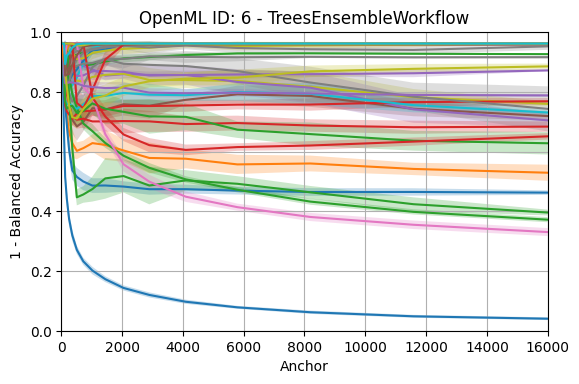

In [164]:
import matplotlib.pyplot as plt

from deephyper.analysis._matplotlib import figure_size

FIGSIZE = figure_size(252 * 1.8, fraction=1.0)

plt.figure(figsize=FIGSIZE)
plt.title(f"OpenML ID: {openml_id} - {workflow}")

for group_i, group_df in df.groupby("job_id"):
    anchors = group_df["ANCHORS"].values
    idx_max = np.argmax([len(a) for a in anchors])
    anchors = anchors[idx_max]
    metrics = np.array(list(zip_longest(*group_df["METRICS"].values, fillvalue=np.nan))).T
    if len(metrics) == 0:
        continue
    means = np.nanmean(metrics, axis=0)
    stds = np.nanstd(metrics, axis=0)
    # ci = 1.96 * stds
    ci = stds

    anchors = anchors[:len(means)]

    plt.plot(anchors, means, label=group_i)
    plt.fill_between(anchors, means - ci, means + ci, alpha=0.25)

plt.xlabel("Anchor")
plt.ylabel("1 - Balanced Accuracy")
# plt.yscale("log")
# plt.xscale("log")
plt.ylim(0, 1)
plt.xlim(0, anchors[-1])
plt.grid()
plt.show()

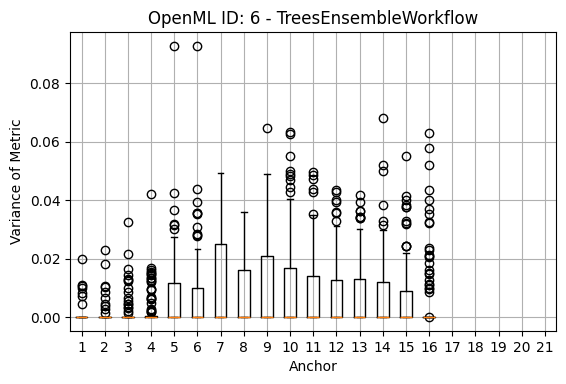

In [173]:
plt.figure(figsize=FIGSIZE)
plt.title(f"OpenML ID: {openml_id} - {workflow}")

stds = []

for group_i, group_df in df.groupby("job_id"):
    metrics = np.array(list(zip_longest(*group_df["METRICS"].values, fillvalue=np.nan))).T
    if len(metrics) == 0:
        continue
    stds.append(np.nanstd(metrics, axis=0))

stds = np.array(list(zip_longest(*stds, fillvalue=np.nan))).T
# stds = np.nanmean(stds, axis=0)
# stds = np.nanmedian(stds, axis=0)
# plt.plot(stds)
plt.boxplot(stds, showfliers=True)

plt.xlabel("Anchor")
plt.ylabel("Variance of Metric")
# plt.yscale("log")
# plt.xscale("log")
# plt.ylim(0, 1)
# plt.xlim(0, anchors[-1])
plt.grid()
plt.show()

In [165]:
anchors

[16,
 23,
 32,
 45,
 64,
 91,
 128,
 181,
 256,
 362,
 512,
 724,
 1024,
 1448,
 2048,
 2896,
 4096,
 5793,
 8192,
 11585,
 16000]